## Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
import plotly.express as px
from matplotlib import pylab
from matplotlib.colors import TwoSlopeNorm

import sys
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

warnings.filterwarnings('ignore')

/group/testa/Users/davide.castaldi/Polaroid_publication_revisions/.local/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==56.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [2]:
RelevantAreas = ["pfc","temporal","somatosensory"]
outdir="./outdir"
FinaLeaf="/Cycling"

ThreePointsDEGs = outdir+FinaLeaf+"/03C_Badhuri_Cycling.3pointsModel.pBulk_byArea.scaled.DEGs.filtered.tsv"
adataPath = outdir+FinaLeaf+"/5C_Cycling_pBulk.bySegment.10PRs.h5ad"

groupingCovariate = "regionContrast"

adataPathBadhuri = outdir+FinaLeaf+"/Badhuri_cycling_pBulk.Curated.20PRs.bycortical_area.h5ad"



if not os.path.exists('./figures'):
    os.makedirs('./figures')

if not os.path.exists('./tables'):
    os.makedirs('./tables')



In [3]:
print(pd.read_csv(ThreePointsDEGs, sep = "\t", index_col=0).sort_values(by = "FWER", ascending = True).shape)


(275, 7)


In [4]:
%matplotlib inline

In [5]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')
pylab.rcParams['figure.figsize'] = (10, 10)


scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.22.2 scipy==1.10.1 pandas==1.2.3 scikit-learn==0.24.2 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


### Configure paths

In [6]:
hostRoot = "-".join(socket.gethostname().split('-')[0:2])

with open(os.path.expanduser('~')+"/paths_config.yaml", 'r') as f:
    paths = yaml.load(f, Loader=yaml.FullLoader)

#indir=paths["paths"]["indir"][hostRoot]
#projectBaseDir=paths["paths"]["projectBaseDir"][hostRoot]



## 3 points model DEGs

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


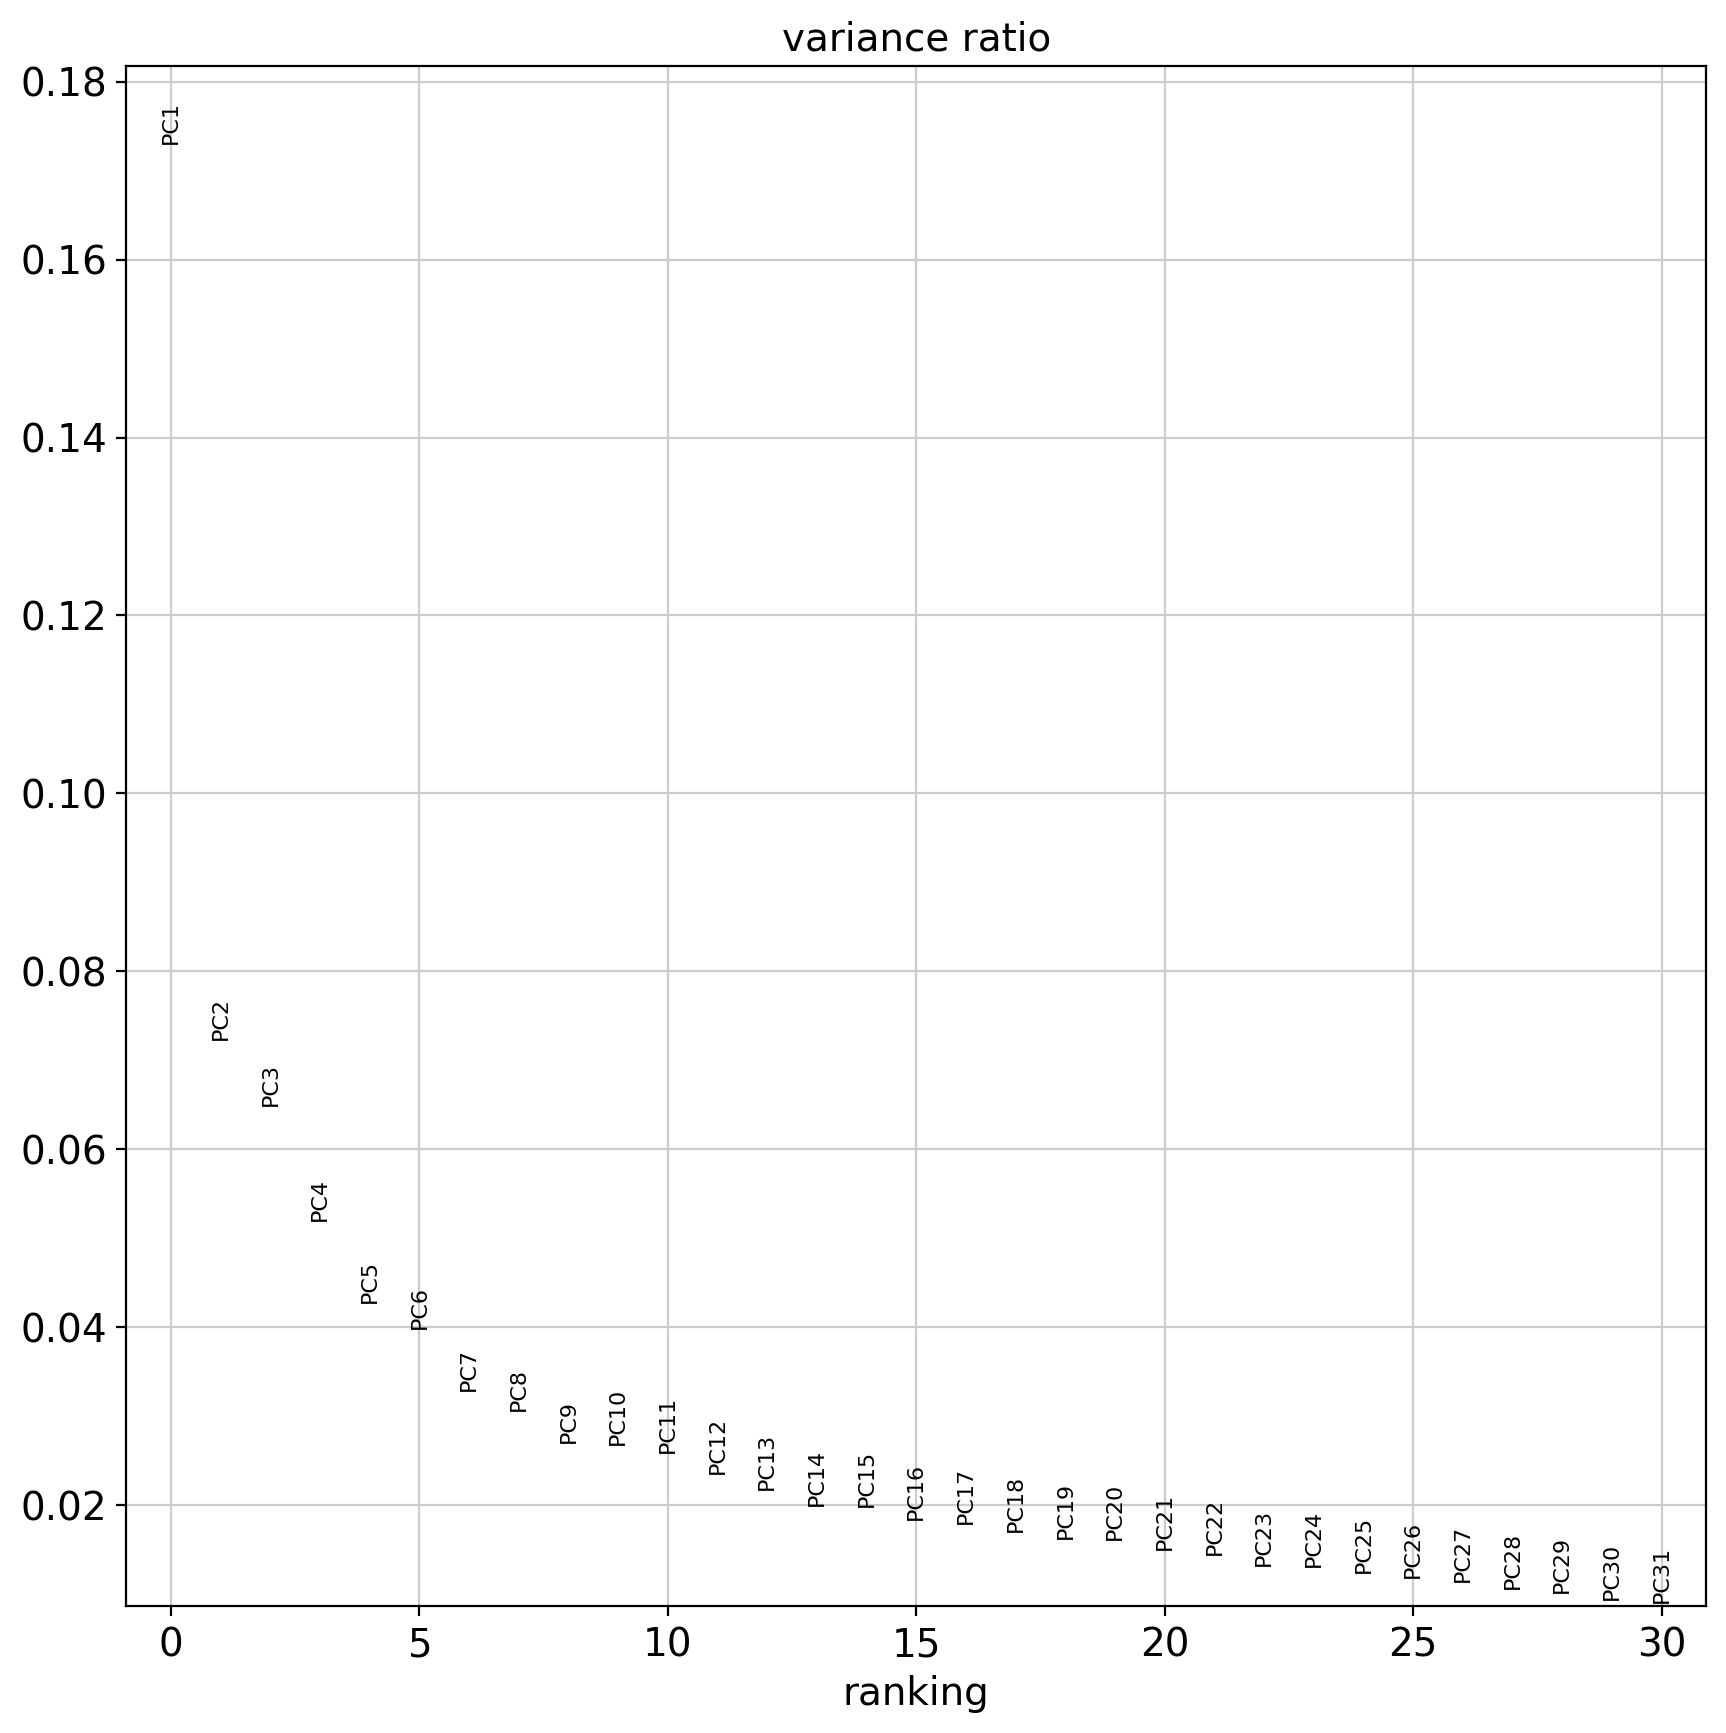

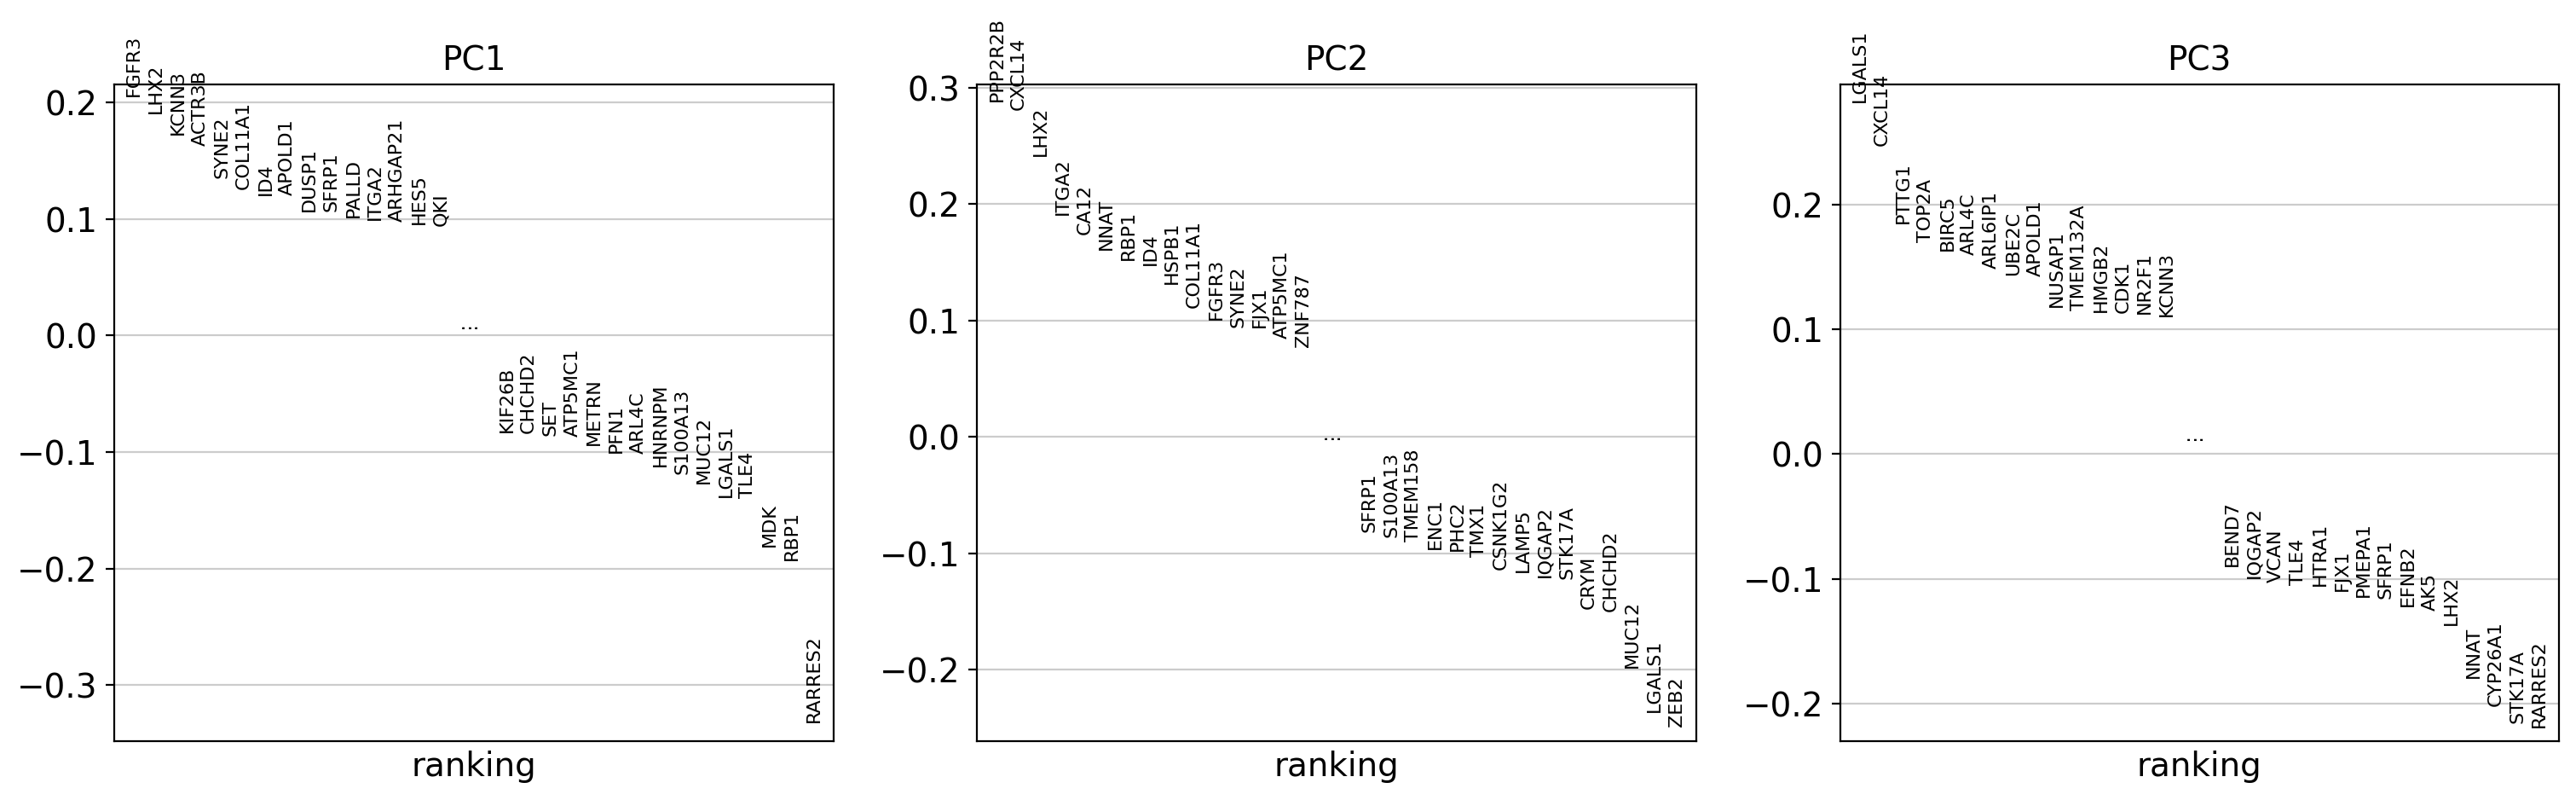

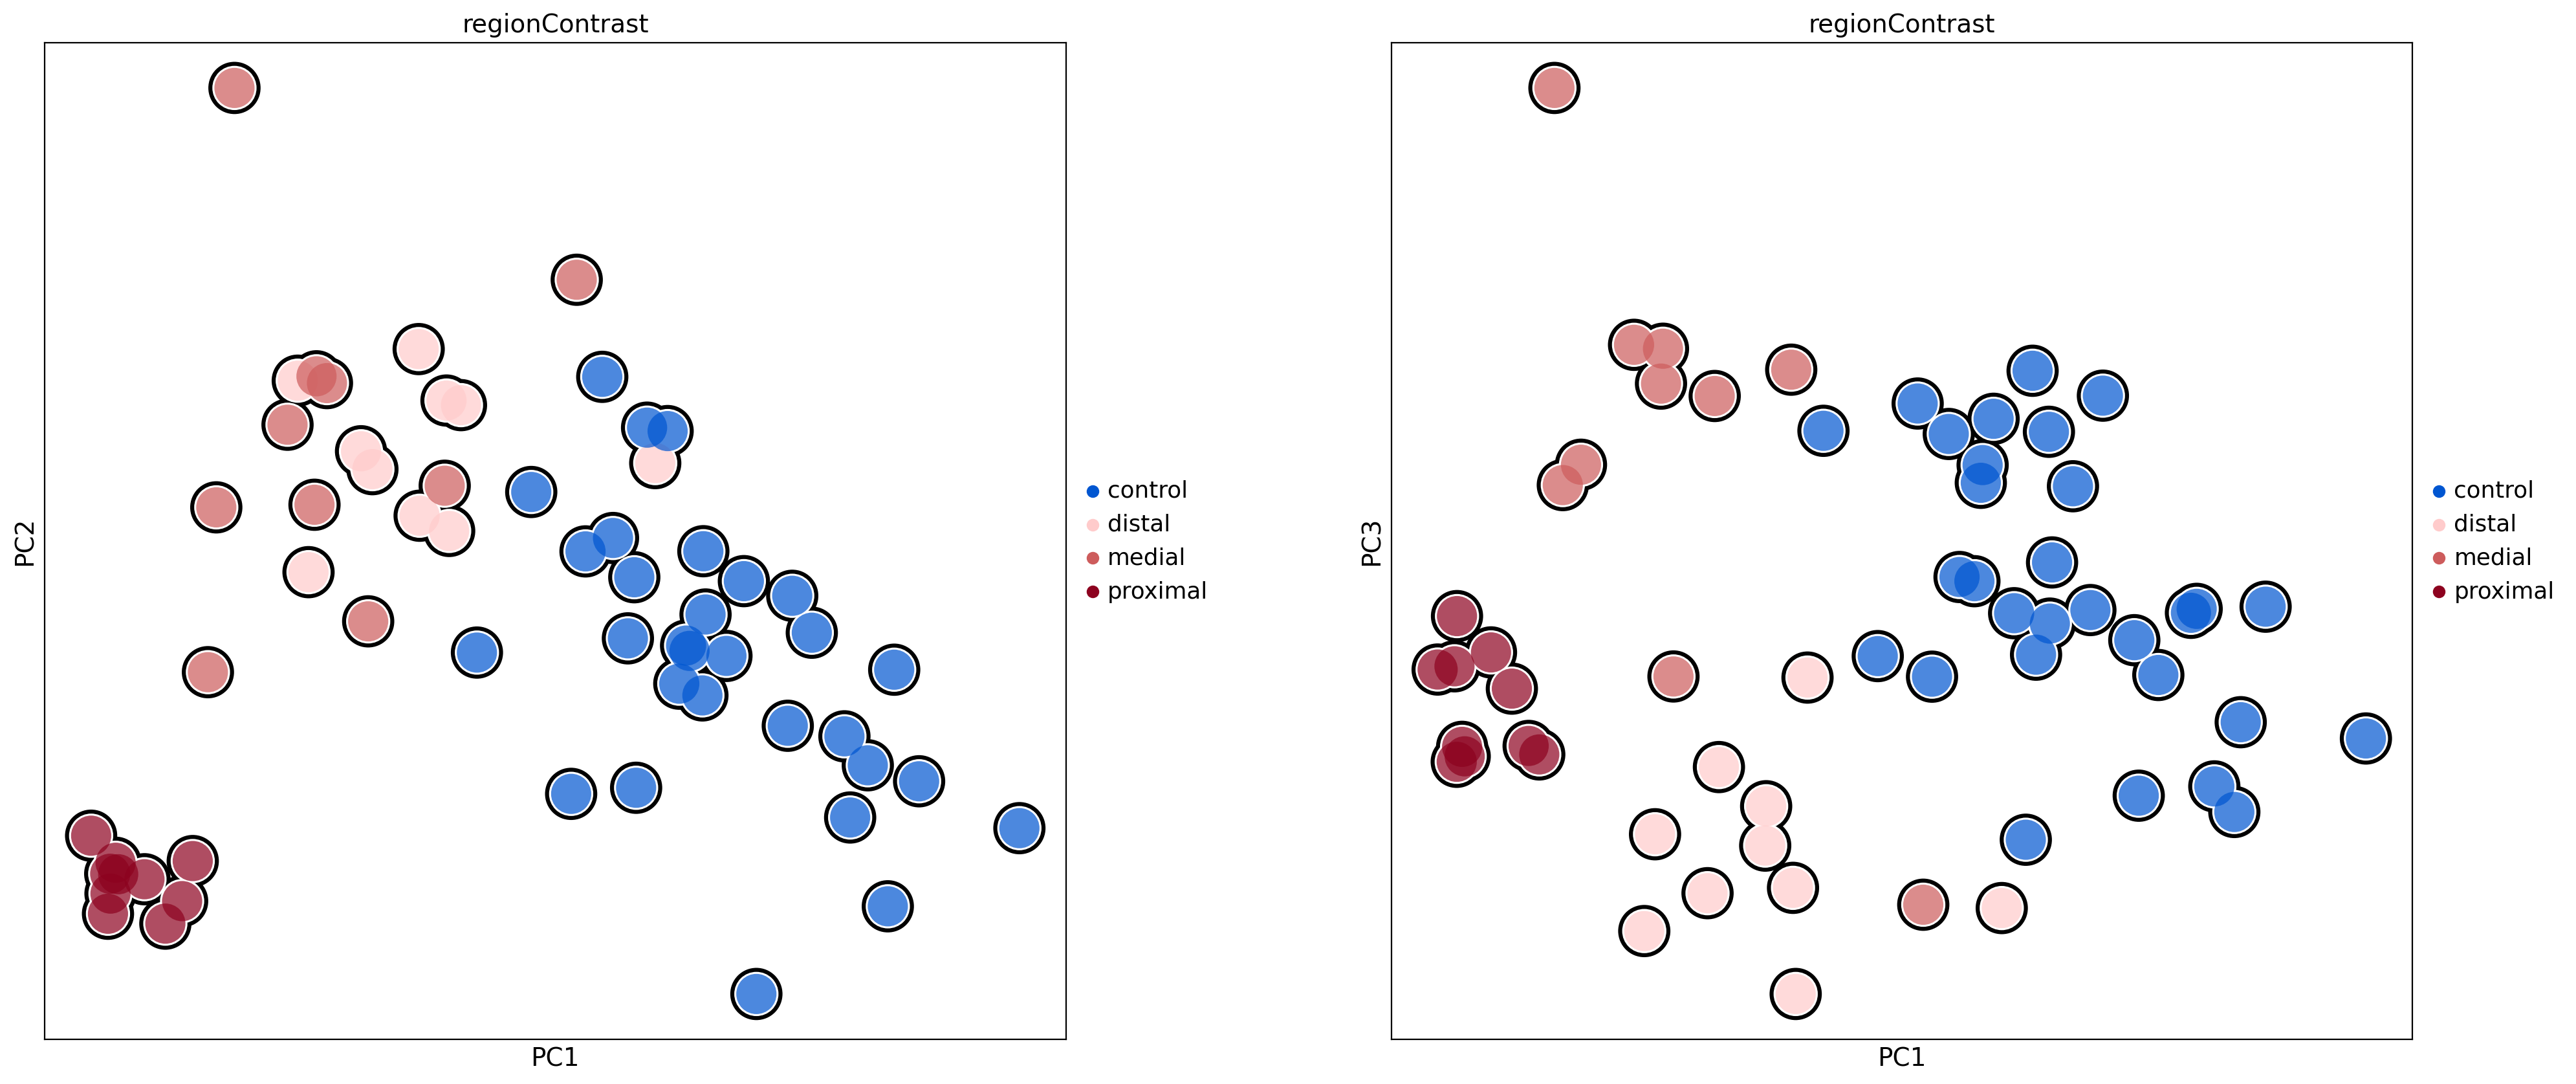

In [7]:

adata = sc.read_h5ad(adataPath)
#adata=adata[adata.obs["type"] == "polaroid"]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
NowaDEGs_3Points = pd.read_csv(ThreePointsDEGs, sep = "\t", index_col=0)
adata = adata[:,list(set(adata.var_names).intersection(NowaDEGs_3Points.index))]
#sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, use_highly_variable=False)

sc.pl.pca_variance_ratio(adata)

pylab.rcParams['figure.figsize'] = (6, 5)
sc.pl.pca_loadings(adata)

pylab.rcParams['figure.figsize'] = (10, 10)


#sc.pl.pca(adata, components=['1,2','1,3'], color=[groupingCovariate]+[m for m in highConf if m in adata.var_names.tolist()], ncols=2, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)
sc.pl.pca(adata, components=['1,2','1,3'], color="regionContrast", ncols=2, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)


#store varm pca for later projection
loadings = adata.varm["PCs"]


In [8]:
# Proximal/pfc always right left
if adata[adata.obs["group"] == "proximal"].obsm["X_pca"][:,0].mean() > adata[adata.obs["group"] == "distal"].obsm["X_pca"][:,0].mean():
    adata.varm["PCs"] = -adata.varm["PCs"]
    adata.obsm["X_pca"] = -adata.obsm["X_pca"]


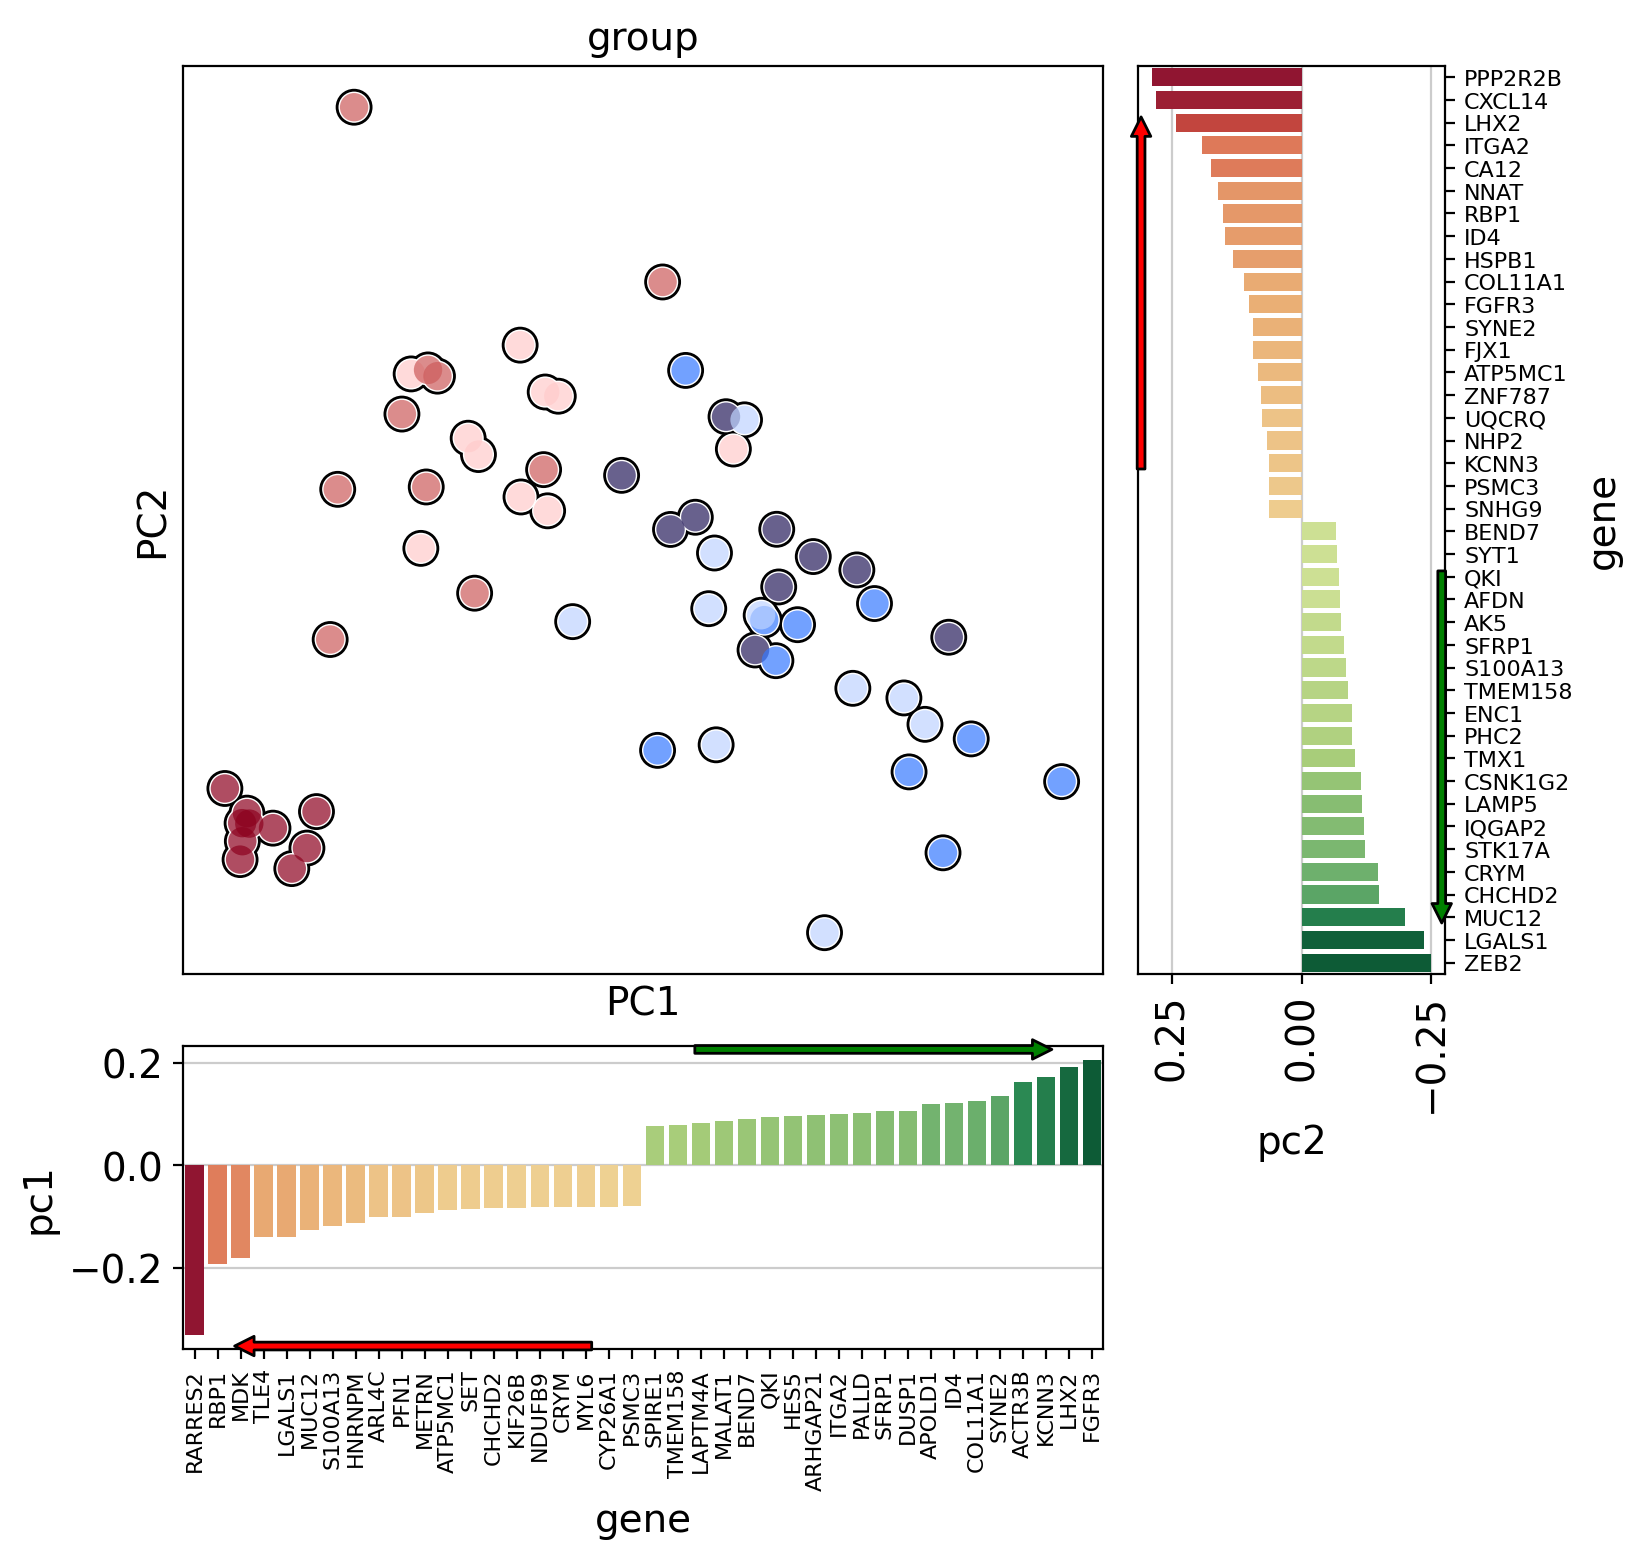

In [9]:
#if you want vector sc.settings._vector_friendly = False
vector=True
n=20
color="group"
pcsToAssess = [0,1]
adataObj = adata


##################


dotsize = 25000/adataObj.shape[0]

pdDict = {}
if vector:
    sc.settings._vector_friendly = False
for pc in  pcsToAssess:
    TopPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adataObj.varm["PCs"][:,pc][TopPC_IDX], index = adataObj.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adataObj.varm["PCs"][:,pc][DownPC_IDX], index = adataObj.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == pcsToAssess[0]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == pcsToAssess[1]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (n/3.3333, n/3.3333)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adataObj, components=",".join([str(i+1) for i in pcsToAssess]), color=[color], 
                    ncols=1, add_outline=True, legend_loc="None",size=dotsize,legend_fontsize="xx-small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)]]
sns.barplot(data=pdDict[pcsToAssess[0]], x="gene", y="pc"+str(pcsToAssess[0]+1), hue="pc"+str(pcsToAssess[0]+1),palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[1][0].get_legend().remove()


norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)]]
sns.barplot(data=pdDict[pcsToAssess[1]], x="pc"+str(pcsToAssess[1]+1), y="gene", hue="pc"+str(pcsToAssess[1]+1),palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].get_legend().remove()
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True

In [10]:
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = "".join(os.path.basename(globals()["__vsc_ipynb_file__"]).split(".")[:-1])
    

In [11]:
fig.savefig("./figures/"+nb_fname+".PCA.pdf",
           bbox_inches="tight")

In [12]:
obsTable = adataObj.obs.copy()
obsTable["PC1"] = adata.obsm["X_pca"][:,0].flatten()
obsTable["PC2"] = adata.obsm["X_pca"][:,1].flatten()
obsTable
obsTable.to_excel("./tables/ExtendedFig9B.cycling.loadings.xlsx")

pd.concat([
    pdDict[0].rename(columns={"pc1":"loading"}).assign(component=1),
    pdDict[1].rename(columns={"pc2":"loading"}).assign(component=2)],
          ignore_index=True).to_excel("./tables/ExtendedFig9B.cycling.PCA.xlsx")